# Fake News
## Table of Contents
<ul>
<li>Introduction</li>
<li>Importing The Libraries</li>
<li>Reading The Data</li>
<li>Data Inspection</li>
<li>Data Preprocessing</li>
<li>Building Model</li>
<li>Evaluating Model Performance</li>
</ul>

# Introduction

- In this project i will predict if the news are real or fake.

  The definition for each feature:
     - id: unique id for a news article
     - title: the title of a news article
     - author: author of the news article
     - text: the text of the article; could be incomplete
     - label: a label that marks the article as potentially unreliable
                             1: unreliable
                             0: reliable

# Importing The Libraries

In [39]:
import pandas as pd
import nltk
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# Reading The Data

In [2]:
df=pd.read_csv("train.csv")

# Data Inspection

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.shape

(20800, 5)

- No.of records : 20800
- No.of features: 5 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


- There are some missing values.
- Three features are categorical.
- Two features are numerical.

In [6]:
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

- There are 558 missing value in title, 1957 missing value in author and 39 missing value in text.

# Data Preprocessing

In [7]:
df.fillna('unknown',inplace=True)

In [8]:
df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

- Data are clean.

In [9]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
#Concatenating the two features author and title 
df["content"]=df["author"] + ' ' + df["title"]

#Dropping useless features
df.drop(["author",'title','id'],axis=1,inplace=True)

df.head()

,text,label,content
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


In [12]:
#Downloading the stop words
nltk.download('stopwords')

True

In [13]:
#Taking an object from the class PorterStemmer
prt_stm=PorterStemmer()

#Defining a function
def portr_stmr(txt):
    '''
    This function for applying the PorterStemmer on the text.
    INPUT:
    txt: str. A text.
    OUTPUT:
    Returning stemmed text.
    '''
    re_opr=re.sub('[^a-zA-Z]',' ',txt)
    lower_txt=re_opr.lower()
    split_opr=lower_txt.split()
    stemmed_txt=[prt_stm.stem(word) for word in split_opr if word not in stopwords.words("english")]
    stemmed_txt=" ".join(stemmed_txt)
    return stemmed_txt

#Applying the portr_stmr function on the content feature
df["content"]=df["content"].apply(portr_stmr)

In [14]:
#Displaying the first five records from content feature
df["content"].head()

0    darrel lucu hous dem aid even see comey letter...
1    daniel j flynn flynn hillari clinton big woman...
2               consortiumnew com truth might get fire
3    jessica purkiss civilian kill singl us airstri...
4    howard portnoy iranian woman jail fiction unpu...
Name: content, dtype: object

In [15]:
#Splitting the data to x and y
x=df["content"].values
y=df["label"].values

In [16]:
x

array(['darrel lucu hous dem aid even see comey letter jason chaffetz tweet',
       'daniel j flynn flynn hillari clinton big woman campu breitbart',
       'consortiumnew com truth might get fire', ...,
       'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time',
       'alex ansari nato russia hold parallel exercis balkan',
       'david swanson keep f aliv'], dtype=object)

In [17]:
y

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [18]:
#Applying TfidfVectorizer
vectorizer=TfidfVectorizer()
vectorizer.fit(x)
x=vectorizer.transform(x)

In [19]:
print(x)

  (0, 15686)	0.28485063562728646
  (0, 13473)	0.2565896679337957
  (0, 8909)	0.3635963806326075
  (0, 8630)	0.29212514087043684
  (0, 7692)	0.24785219520671603
  (0, 7005)	0.21874169089359144
  (0, 4973)	0.233316966909351
  (0, 3792)	0.2705332480845492
  (0, 3600)	0.3598939188262559
  (0, 2959)	0.2468450128533713
  (0, 2483)	0.3676519686797209
  (0, 267)	0.27010124977708766
  (1, 16799)	0.30071745655510157
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (1, 2813)	0.19094574062359204
  (1, 2223)	0.3827320386859759
  (1, 1894)	0.15521974226349364
  (1, 1497)	0.2939891562094648
  (2, 15611)	0.41544962664721613
  (2, 9620)	0.49351492943649944
  (2, 5968)	0.3474613386728292
  (2, 5389)	0.3866530551182615
  (2, 3103)	0.46097489583229645
  :	:
  (20797, 13122)	0.2482526352197606
  (20797, 12344)	0.27263457663336677
  (20797, 12138)	0.24778257724396507
  (20797, 10306)	0.08038079000566466
  (20797, 9588)	0.174553480255222
  (20797, 9518)	0.295420

# Building Model

In [21]:
#Logistic regression model
lr=LogisticRegression()

In [23]:
#Applying cross_validate
cross_val=cross_validate(lr,x,y,cv=10,n_jobs=-1,return_train_score=True)

In [24]:
cross_val

{'fit_time': array([0.203022  , 0.17266965, 0.1410172 , 0.34693766, 0.32930303,
        0.37657833, 0.36094642, 0.37657833, 0.1455605 , 0.14100718]),
 'score_time': array([0.        , 0.        , 0.        , 0.01400876, 0.01562047,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'test_score': array([0.98317308, 0.98317308, 0.98125   , 0.98028846, 0.98701923,
        0.98076923, 0.98221154, 0.98365385, 0.98461538, 0.98269231]),
 'train_score': array([0.99081197, 0.9911859 , 0.99145299, 0.99107906, 0.99086538,
        0.99161325, 0.99097222, 0.9909188 , 0.99129274, 0.99097222])}

# Evaluating Model Performance

In [25]:
#Training score
cross_val["train_score"].mean()

0.9911164529914531

In [26]:
#Testing score
cross_val["test_score"].mean()

0.9828846153846154

In [28]:
#Obtaining the predicted values
y_pred=cross_val_predict(lr,x,y,cv=10,n_jobs=-1)
y_pred

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [30]:
#Accuracy score
accuracy_score(y,y_pred)

0.9828846153846154

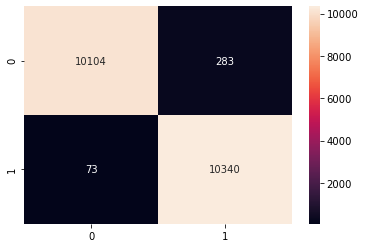

In [49]:
#Confusion matrix
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='1');

- The much cost in this problem if we predict that the news aren't fake but it is fake. In the confusion matrix we can see that the model prediction incorrect in this case in 73 predicted value, so the model worked well since the model has a small error in this case.

In [33]:
#Classification report
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10387
           1       0.97      0.99      0.98     10413

    accuracy                           0.98     20800
   macro avg       0.98      0.98      0.98     20800
weighted avg       0.98      0.98      0.98     20800

